<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

from networkx.algorithms.community import k_clique_communities, fast_label_propagation_communities, louvain_communities, greedy_modularity_communities
from networkx.algorithms.components import connected_components



BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

Python Environment:
 | Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.9.0
 | NetworkX version: 3.3
 | NetworkX backend: None
 | CuGraph not installed, for better performance install it like this:
	pip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

Ressources:
 | CPU: 12 cores


## Daten laden

In [2]:
G = utils.get_graph(GRAPH_PATH, PAPERS)

print(f"Number of nodes: {len(G.nodes)}")
G = utils.merge_duplicate_nodes(
    G, exclude_attributes=["label", "countries", "sourceID", "valid_until", "note"]
)
print(f"Number of nodes after removing duplicates: {len(G.nodes)}")

print(f"Number of edges: {len(G.edges)}")
G = utils.remove_duplicate_edges(G)
print(f"Number of edges after removing duplicates: {len(G.edges)}")

Number of nodes: 108053


Merging duplicate nodes:   0%|          | 0/89015 [00:00<?, ?it/s]

Number of nodes after removing duplicates: 89015
Number of edges: 126762


Removing duplicate edges:   0%|          | 0/126762 [00:00<?, ?it/s]

Number of edges after removing duplicates: 111962


## Which are the biggest officer clusters/cliques, and what percentage of Swiss officers are part of them?

In [3]:
def unweighted_project_officers_graph(G):
    undirected_G = G.to_undirected()

    officers_nodes = {node for node, data in undirected_G.nodes(data=True) if data.get("node_type") == "Officer"}

    connecting_entities = 0

    new_G = nx.Graph()
    for node in officers_nodes:

        # Check if the officer is related to an address or entity
        related_nodes = set()
        for neighbor in undirected_G.neighbors(node):
            neighbor_data = undirected_G.nodes[neighbor]
            if neighbor_data.get("node_type") == "Address" or neighbor_data.get("node_type") == "Entity":
                related_nodes.add(neighbor)

        # Add edges between officers if they share the same address or entity
        for related_node in related_nodes:
            for neighbor in undirected_G.neighbors(related_node):
                if neighbor in officers_nodes and neighbor != node:
                    related_data = undirected_G.nodes[related_node]
                    if related_data.get("node_type") == "Entity" and not new_G.has_edge(node, neighbor):
                        connecting_entities += 1
                    new_G.add_edge(node, neighbor)

    return new_G, connecting_entities

new_officers_graph, connecting_entities = unweighted_project_officers_graph(G)

In [4]:
num_nodes = len(new_officers_graph.nodes)
num_edges = len(new_officers_graph.edges)

print("Number of nodes in the new officers graph:", num_nodes)

all_officers_nodes = {node for node, data in G.nodes(data=True) if data.get("node_type") == "Officer"}

swiss_officers_nodes = {node for node, data in G.nodes(data=True) if utils.is_officer_from_country_name(G, node, "Switzerland")}

swiss_officers_to_all_officers_ratio = len(swiss_officers_nodes)/len(all_officers_nodes)

print(f"Ratio of swiss officers: {swiss_officers_to_all_officers_ratio}")
print()

print("Number of edges in the new officers graph:", num_edges)
print(f"Number of edges in the new officers graph which stem from entities: {connecting_entities} ({connecting_entities/num_edges:.2%})")
print(f"Number of edges in the new officers graph which stem from addresses: {num_edges-connecting_entities} ({(num_edges-connecting_entities)/num_edges:.2%})")
print()

max_possible_edges = num_nodes * (num_nodes - 1) / 2
edge_ratio = num_edges / max_possible_edges if max_possible_edges > 0 else 0

print("Edge ratio (edges / max possible edges):", edge_ratio, "which is equivalent to", edge_ratio * 100, "%")


Number of nodes in the new officers graph: 20941
Ratio of swiss officers: 0.022714366837024418

Number of edges in the new officers graph: 34916
Number of edges in the new officers graph which stem from entities: 28522 (81.69%)
Number of edges in the new officers graph which stem from addresses: 6394 (18.31%)

Edge ratio (edges / max possible edges): 0.00015925034664407352 which is equivalent to 0.015925034664407353 %


The new graph consists of 21k Officers (of which 2.27% are Swiss) and 35k Connections between them. More than 80% of the newly created edges between the officers do not stem from addresses but (also) from entities they are connected to. This is important. Because officers having the same address will be a clique for sure and the ratio of swiss officers will be 100% or 0% depending on the address. But the fact that entities are also a connecting factor, makes the graph even interesting in the first place. As that's the only source where cliques can be multinational.

In [5]:
def plot_swiss_officer_ratios_by_group(G, group_callback, grouping_method):
    """
    Plots the distribution of Swiss officer ratios in groups of nodes.
    Creates two subplots:
    - A histogram of the distribution of Swiss officer ratios in groups
    - A bar chart of the mean Swiss officer ratio by group size
    """
    # get groups of nodes according to the given grouping method
    groups = list(group_callback(G))

    swiss_ratio_by_size = {}
    groups_ratios = []

    for group in groups:
        group_size = len(group)
        
        # Count the number of Swiss officers in the group and calculate the ratio
        swiss_count = sum(1 for node in group if node in swiss_officers_nodes)
        swiss_ratio = swiss_count / group_size if group_size > 0 else 0
        
        # Skip groups with size 1
        if group_size > 1:
            groups_ratios.append(swiss_ratio)
        
        if group_size not in swiss_ratio_by_size:
            swiss_ratio_by_size[group_size] = {"total_groups": 0, "swiss_count": 0}
        
        swiss_ratio_by_size[group_size]["total_groups"] += 1
        swiss_ratio_by_size[group_size]["swiss_count"] += swiss_count

    for size, data in swiss_ratio_by_size.items():
        total_groups = data["total_groups"]
        swiss_count = data["swiss_count"]
        swiss_ratio = swiss_count / (total_groups * size) if total_groups > 0 else 0
        swiss_ratio_by_size[size]["swiss_ratio"] = swiss_ratio
    
    # Plot the distribution of Swiss officer ratios in groups
    fig, ax = plt.subplots(1, 2, figsize=(24, 6))
    plt.sca(ax[0])
    plt.hist(groups_ratios, edgecolor='black', alpha=0.7, bins=min(20, len(groups)))
    ratio_dist = np.unique(groups_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio in {grouping_method.capitalize()}\n'
              f'Number of unique ratios: {len(ratio_dist)} first five ratios: {ratio_dist[:5] if len(ratio_dist) > 5 else ratio_dist}')
    plt.xlabel('Swiss Officer Ratio')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.grid(True)

    # Plot the mean Swiss officer ratio by group size
    plt.sca(ax[1])
    group_sizes = sorted(swiss_ratio_by_size.keys())
    swiss_ratios = [swiss_ratio_by_size[size]['swiss_ratio'] for size in group_sizes]
    group_counts = [swiss_ratio_by_size[size]['total_groups'] for size in group_sizes]
    bars = plt.bar([str(size) for size in group_sizes], swiss_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio by {grouping_method.capitalize()} Size\n'
              f'(Number of {grouping_method}s: {len(groups)})')
    plt.xlabel(f'{grouping_method.capitalize()} Size')
    plt.ylabel('Mean Swiss Officer Ratio')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.axhline(y=swiss_officers_to_all_officers_ratio, color='red', linestyle='--', label=f'Average Swiss Officer Ratio ({swiss_officers_to_all_officers_ratio:.3f})')
    plt.legend()

    for bar, count in zip(bars, group_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

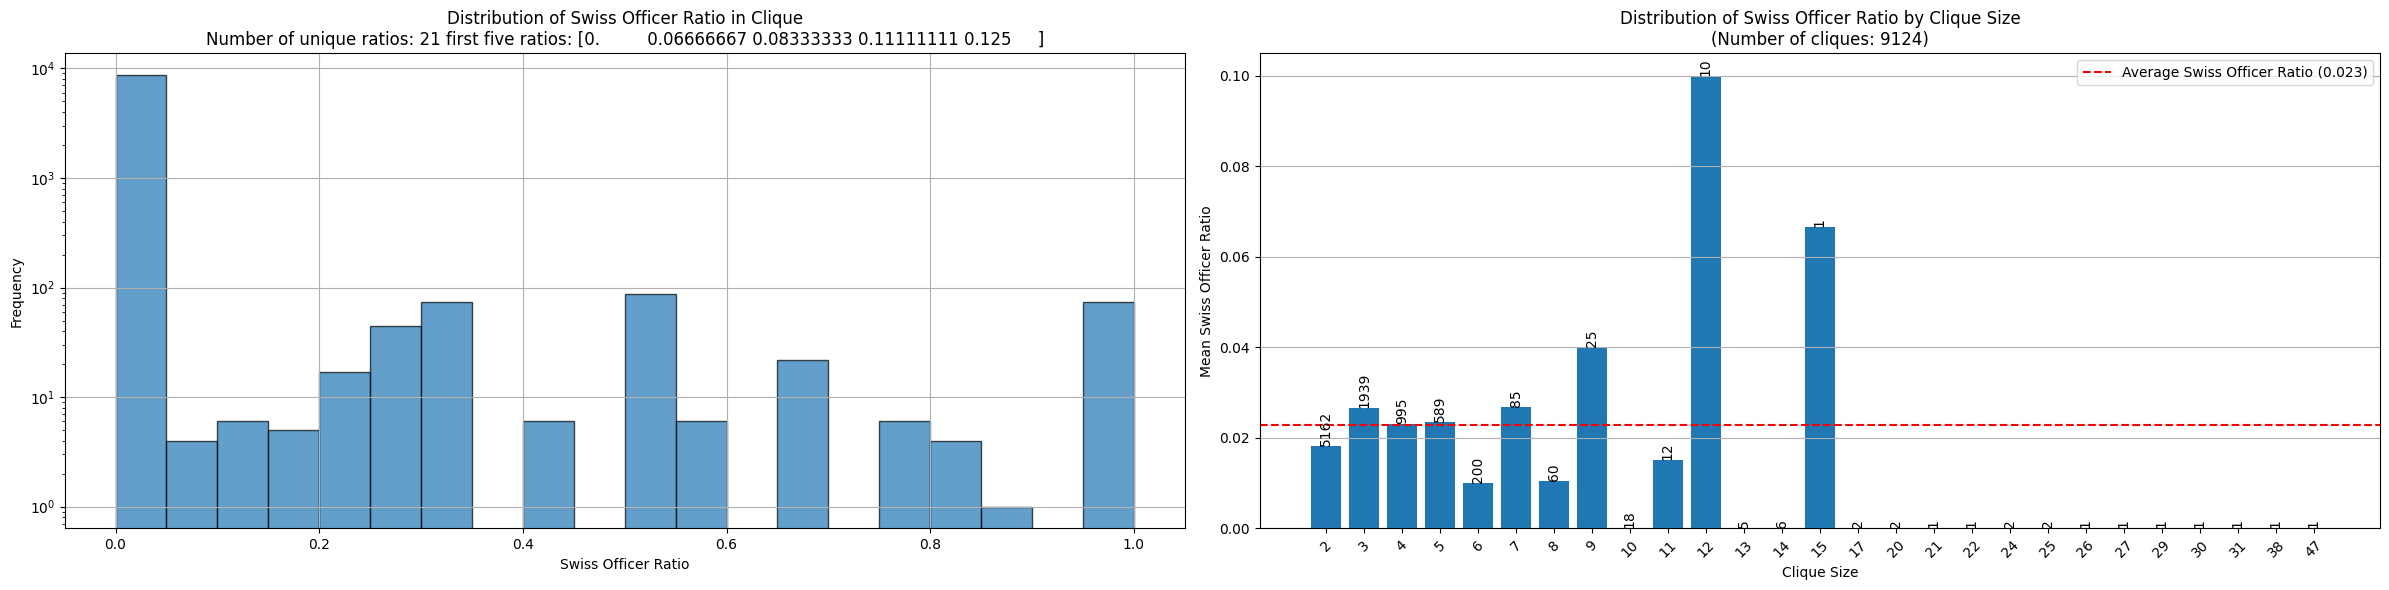

In [6]:
plot_swiss_officer_ratios_by_group(new_officers_graph, nx.find_cliques, 'clique')

Most cliques do not contain any swiss officers. The average swiss officer ratio (on a per clique basis) is 0.0227. There doesnt not seem to be many interesting patterns. One thing that is interesting is that there aren't many cliques where the swiss officer ratio is close to 0 or 1 but not exactly 0 or one (indicated by the histogram). also as the cliques get bigger there seem to be less cliques with any swiss officers. This could be due to the fact that the sample size is too small (there are only very few big cliques).

Let's also investigate the top 10 largest cliques.

In [7]:
def analyse_top_10_groups(G_reduced, group_callback, debug=False):
    groups = list(group_callback(G_reduced))
    print(f"Number of groups: {len(groups)}")
    groups = sorted(groups, key=lambda group: len(group), reverse=True)[:10]
    for i, group in enumerate(groups):
        nationalities = Counter()
        for officer in group:
            for neighbor in G.neighbors(officer):
                if G.nodes[neighbor].get("node_type") == "Address":
                    country = G.nodes[neighbor].get("country_codes")
                    if country == "nan" and debug:
                        print(f"Warning: No country found for address {G.nodes[neighbor]}")
                    nationalities[country] += 1
        print(f"clique {i+1} size: {sum(nationalities.values())}")
        print(nationalities)
        print()

analyse_top_10_groups(new_officers_graph, nx.find_cliques, debug=True)

Number of groups: 9124
clique 1 size: 92
Counter({'VGB': 88, 'nan': 4})

clique 2 size: 38
Counter({'URY': 38})

clique 3 size: 31
Counter({'USA': 31})

clique 4 size: 30
Counter({'URY': 30})

clique 5 size: 43
Counter({'ARG': 39, 'USA': 4})

clique 6 size: 41
Counter({'ARG': 41})

clique 7 size: 12
Counter({'GBR': 10, 'PRT': 1, 'GIB': 1})

clique 8 size: 51
Counter({'VGB': 48, 'nan': 3})

clique 9 size: 11
Counter({'GBR': 10, 'PRT': 1})

clique 10 size: 25
Counter({'URY': 24, 'ARG': 1})



All the big cliques are almost always homogeneous in terms of nationality. Only a few cliques have one officer from another country and only the clique 5 with size 43 has 4 officers from the USA.

We'll try to relax the condition a little bit and see what happens with n-cliques.

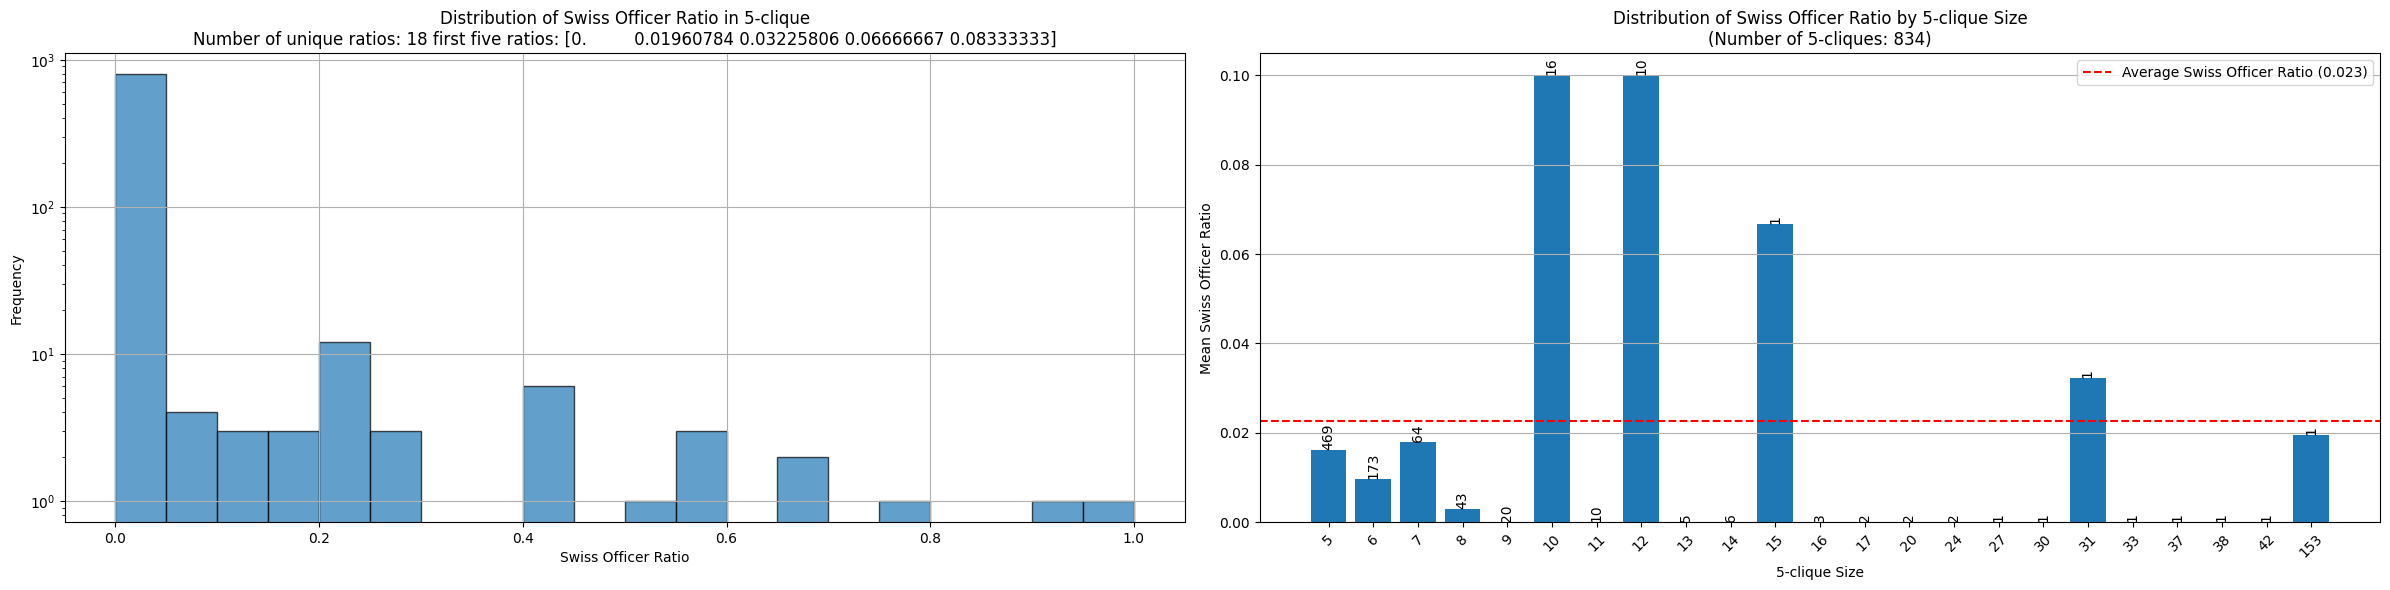

In [8]:
n = 5
plot_swiss_officer_ratios_by_group(new_officers_graph, lambda G: k_clique_communities(G, n), f'{n}-clique')

Nothing to exiciting here. Only interesting thing is the fact that there not many 5-cliques with only swiss officers.


In [9]:
analyse_top_10_groups(new_officers_graph, lambda G: k_clique_communities(G, 5), debug=False)

Number of groups: 834
clique 1 size: 293
Counter({'VGB': 130, 'CYP': 86, 'RUS': 45, 'nan': 16, 'CHE': 3, 'HKG': 3, 'UKR': 2, 'USA': 2, 'KAZ': 2, 'MCO': 2, 'ISR': 1, 'ARE': 1})

clique 2 size: 22
Counter({'GTM': 9, 'SLV': 8, 'COL': 2, 'PER': 2, 'PAN': 1})

clique 3 size: 38
Counter({'URY': 38})

clique 4 size: 51
Counter({'ARG': 47, 'USA': 4})

clique 5 size: 33
Counter({'USA': 33})

clique 6 size: 18
Counter({'GBR': 11, 'PRT': 2, 'CHE': 2, 'IMN': 2, 'GIB': 1})

clique 7 size: 30
Counter({'URY': 30})

clique 8 size: 49
Counter({'HKG': 49})

clique 9 size: 25
Counter({'URY': 24, 'ARG': 1})

clique 10 size: 28
Counter({'KEN': 20, 'GBR': 4, 'nan': 2, 'VGB': 1, 'IMN': 1})



The nationalities inside the cliques are now more mixed but there are still some homogeneous cliques. 

Try with the smallest n-cliques (2-cliques) and see if there are any interesting patterns.

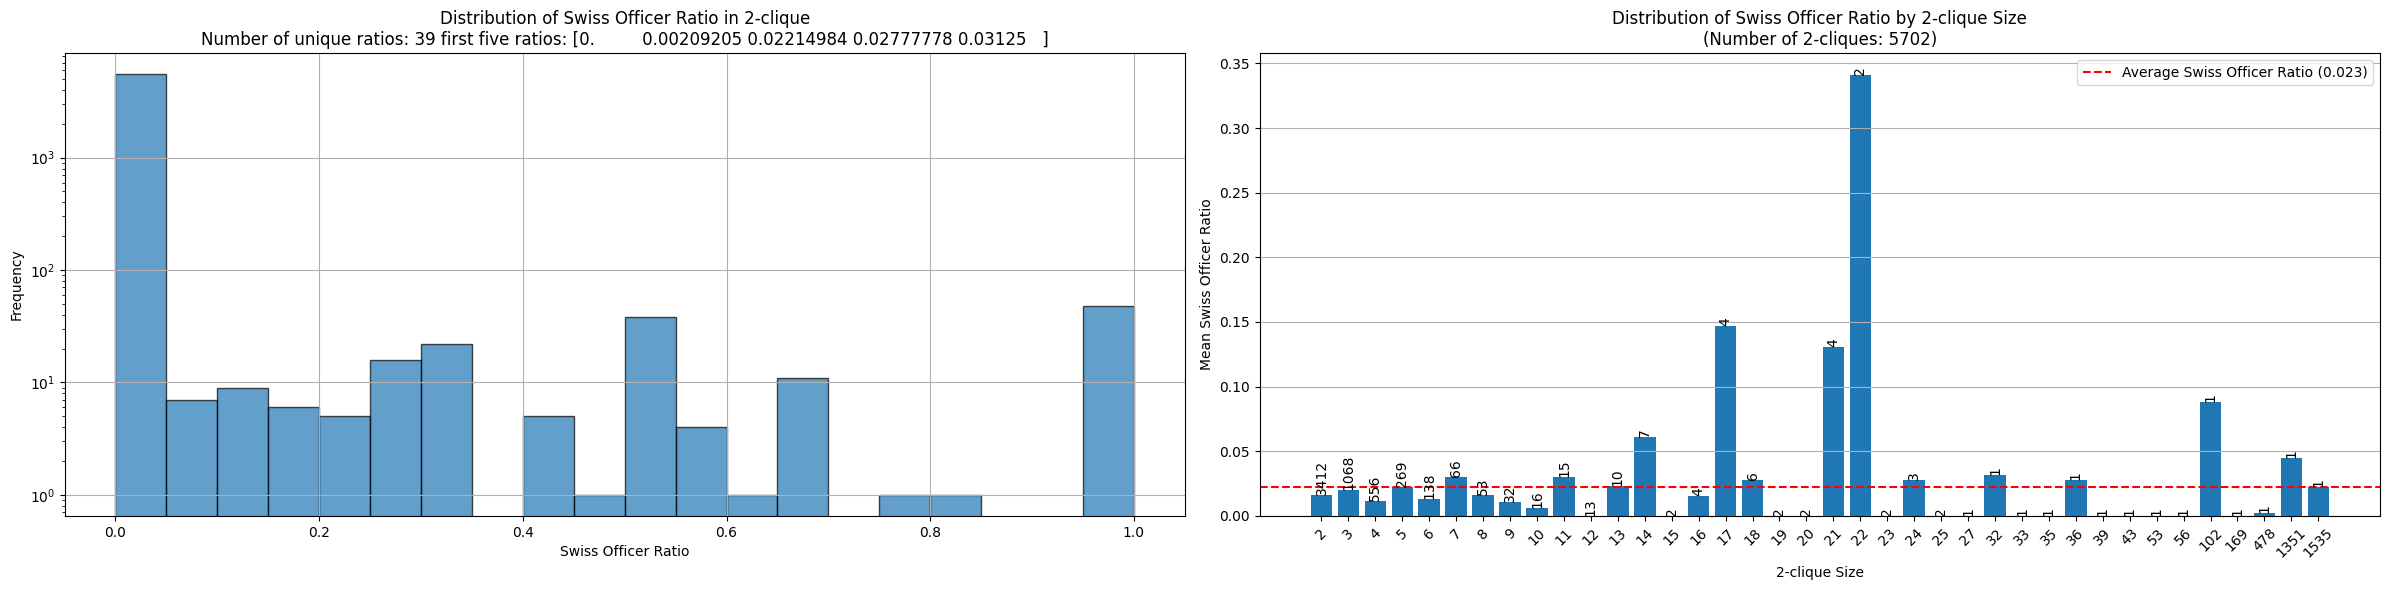

In [10]:
n = 2  # Example value for n
plot_swiss_officer_ratios_by_group(new_officers_graph, lambda G: k_clique_communities(G, n), f'{n}-clique')

This looks more like the original clique analysis. More cliques with ratios close to 1.


In [11]:
analyse_top_10_groups(new_officers_graph, lambda G: k_clique_communities(G, 2), debug=False)

Number of groups: 5702
clique 1 size: 1206
Counter({'GBR': 188, 'ITA': 155, 'ESP': 115, 'DEU': 73, 'FRA': 45, 'BRA': 39, 'NLD': 35, 'CHE': 33, 'PRT': 31, 'ARG': 26, 'ARE': 26, 'ZAF': 23, 'BEL': 22, 'CAN': 22, 'GRC': 21, 'POL': 19, 'RUS': 19, 'NOR': 16, 'TUR': 12, 'FIN': 12, 'AUS': 11, 'BGR': 11, 'SWE': 11, 'AUT': 11, 'ROU': 9, 'VEN': 9, 'USA': 8, 'SVK': 8, 'IRL': 8, 'SVN': 8, 'CZE': 8, 'QAT': 7, 'MYS': 7, 'KEN': 7, 'LBN': 6, 'PAK': 6, 'UKR': 6, 'ISR': 6, 'NGA': 5, 'nan': 5, 'MLT': 5, 'ZMB': 4, 'MCO': 4, 'CIV': 4, 'AGO': 3, 'SRB': 3, 'HRV': 3, 'SAU': 3, 'GHA': 3, 'MEX': 3, 'THA': 3, 'ECU': 3, 'NZL': 3, 'EGY': 3, 'IND': 3, 'AZE': 3, 'CHL': 3, 'MWI': 3, 'HUN': 2, 'JEY': 2, 'HKG': 2, 'TUN': 2, 'DNK': 2, 'BLR': 2, 'VNM': 2, 'SGP': 2, 'MDA': 2, 'PHL': 2, 'MDG': 2, 'NIC': 2, 'MAR': 2, 'LVA': 2, 'PER': 2, 'SMR': 2, 'KAZ': 2, 'DZA': 1, 'BOL': 1, 'COL': 1, 'SYC': 1, 'TZA': 1, 'ALB': 1, 'GEO': 1, 'HND': 1, 'URY': 1, 'CRI': 1, 'UZB': 1, 'BIH': 1, 'JOR': 1, 'BGD': 1, 'CUB': 1, 'MNG': 1, 'CYP': 1, '

Now the cliques are way more heterogeneous.


Relax the condition even more with k-cores and see if there are any interesting patterns.

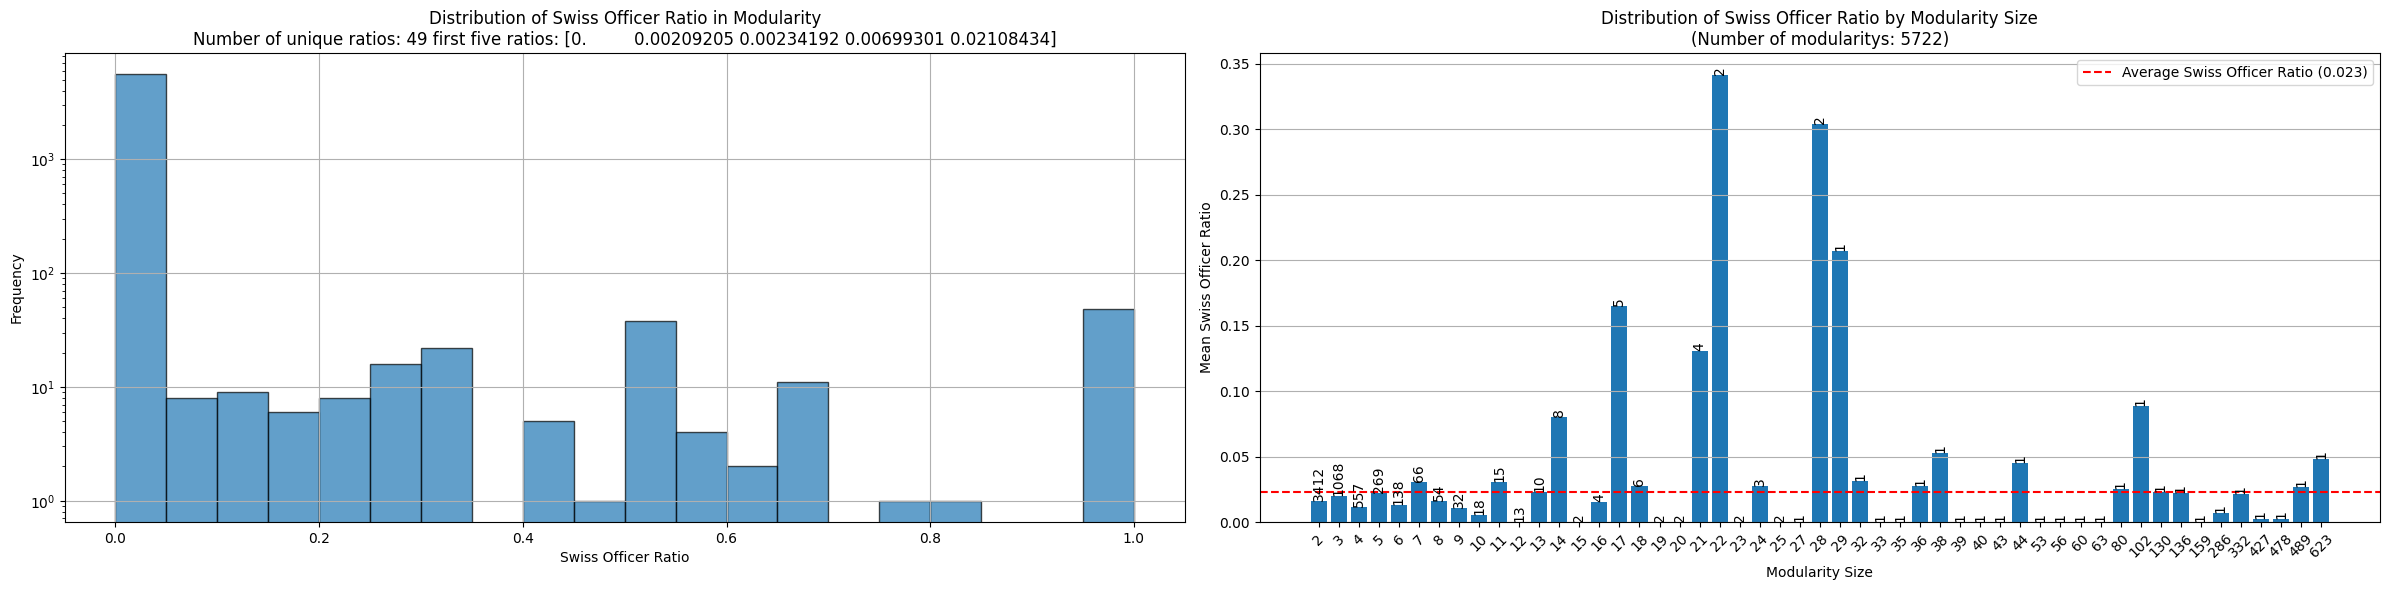

In [12]:
plot_swiss_officer_ratios_by_group(new_officers_graph, greedy_modularity_communities, 'modularity')

The distributions do not seem to be very different from the 2-clique analysis. Most interesting thing is that there are more different sized groups.

In [13]:
analyse_top_10_groups(new_officers_graph, greedy_modularity_communities, debug=False)

Number of groups: 5722
clique 1 size: 829
Counter({'VGB': 241, 'RUS': 156, 'CYP': 133, 'nan': 36, 'CHE': 33, 'ARE': 27, 'HKG': 26, 'SGP': 16, 'JEY': 16, 'GBR': 13, 'UKR': 8, 'ISR': 8, 'CZE': 7, 'KNA': 6, 'GGY': 6, 'HUN': 5, 'MUS': 5, 'AUT': 5, 'GIB': 4, 'SRB': 4, 'KAZ': 4, 'LVA': 4, 'ARM': 4, 'SYC': 4, 'AIA': 3, 'USA': 3, 'MCO': 3, 'PAN': 3, 'BHS': 2, 'MLT': 2, 'ITA': 2, 'DEU': 2, 'IND': 2, 'ROU': 2, 'IMN': 2, 'BHR': 2, 'TUR': 2, 'AZE': 2, 'SAU': 2, 'LUX': 2, 'NLD': 2, 'BRN': 2, 'JOR': 2, 'BLZ': 1, 'FRA': 1, 'LIE': 1, 'BGR': 1, 'ARG': 1, 'MYS': 1, 'IDN': 1, 'LBR': 1, 'CYM': 1, 'BLR': 1, 'PAK': 1, 'HRV': 1, 'AUS': 1, 'TWN': 1, 'VGB;BRN': 1, 'CAN': 1})

clique 2 size: 381
Counter({'ITA': 64, 'GBR': 62, 'ESP': 25, 'DEU': 25, 'ZAF': 15, 'NLD': 15, 'FRA': 14, 'CHE': 14, 'NOR': 11, 'PRT': 9, 'BEL': 7, 'FIN': 7, 'BRA': 7, 'CAN': 6, 'IRL': 6, 'KEN': 6, 'ARE': 6, 'USA': 5, 'POL': 5, 'SVK': 5, 'TUR': 4, 'ISR': 4, 'RUS': 4, 'AUS': 3, 'GRC': 3, 'ROU': 3, 'CZE': 3, 'JEY': 2, 'AUT': 2, 'KAZ': 2, 'NG

The top 10 largest modularity based communities are very heterogeneous in terms of nationality.

Let's try to find whether different communities finding algorithms give us different results.

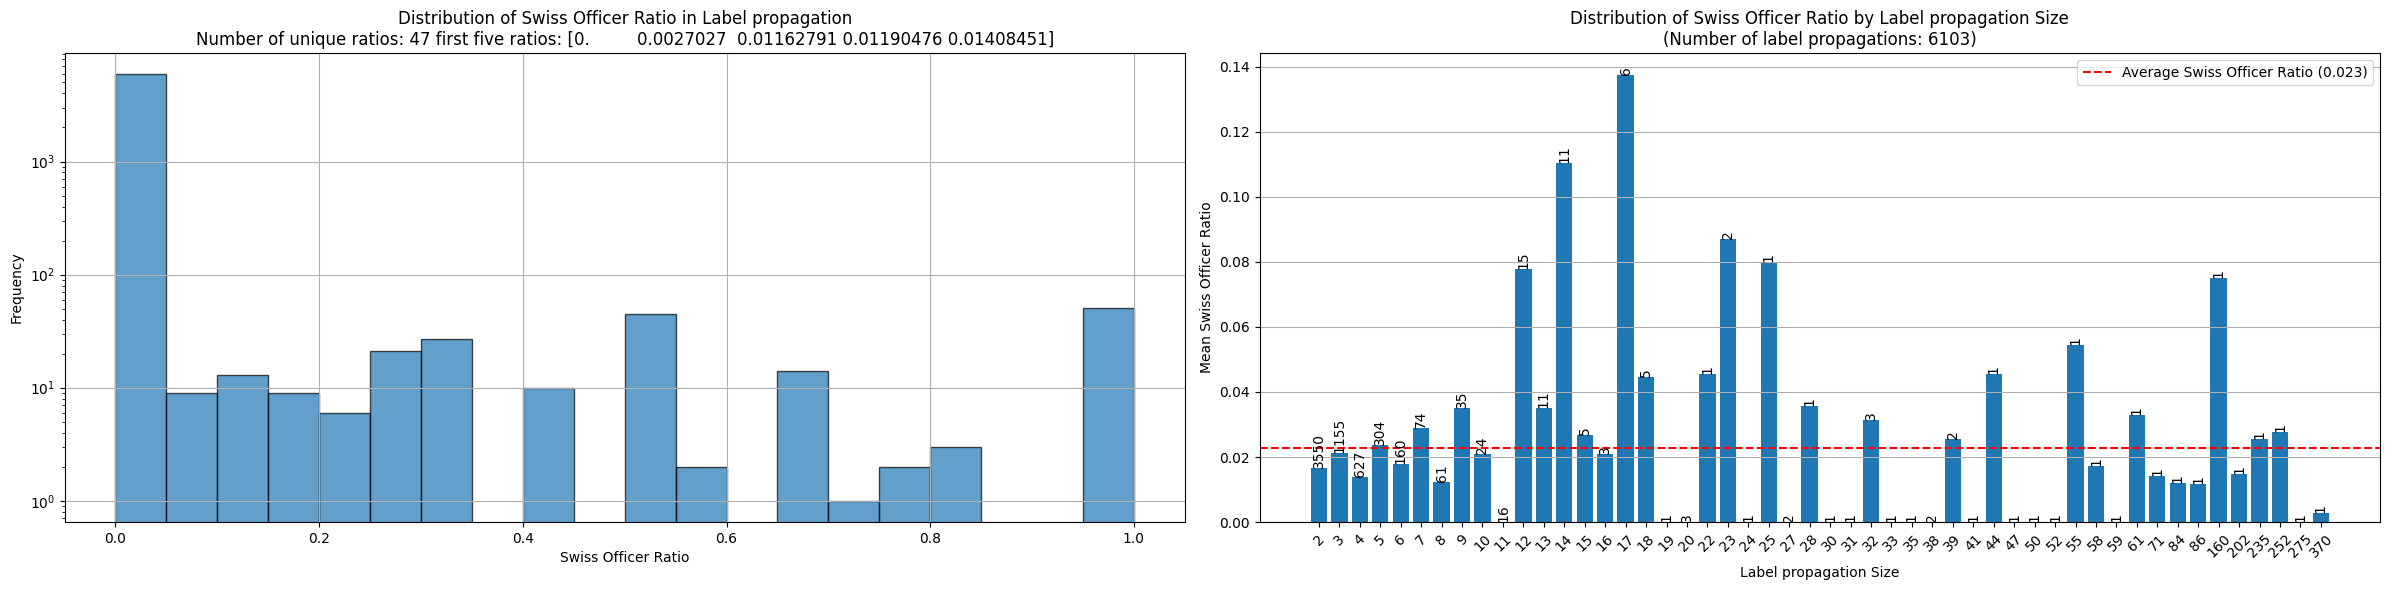

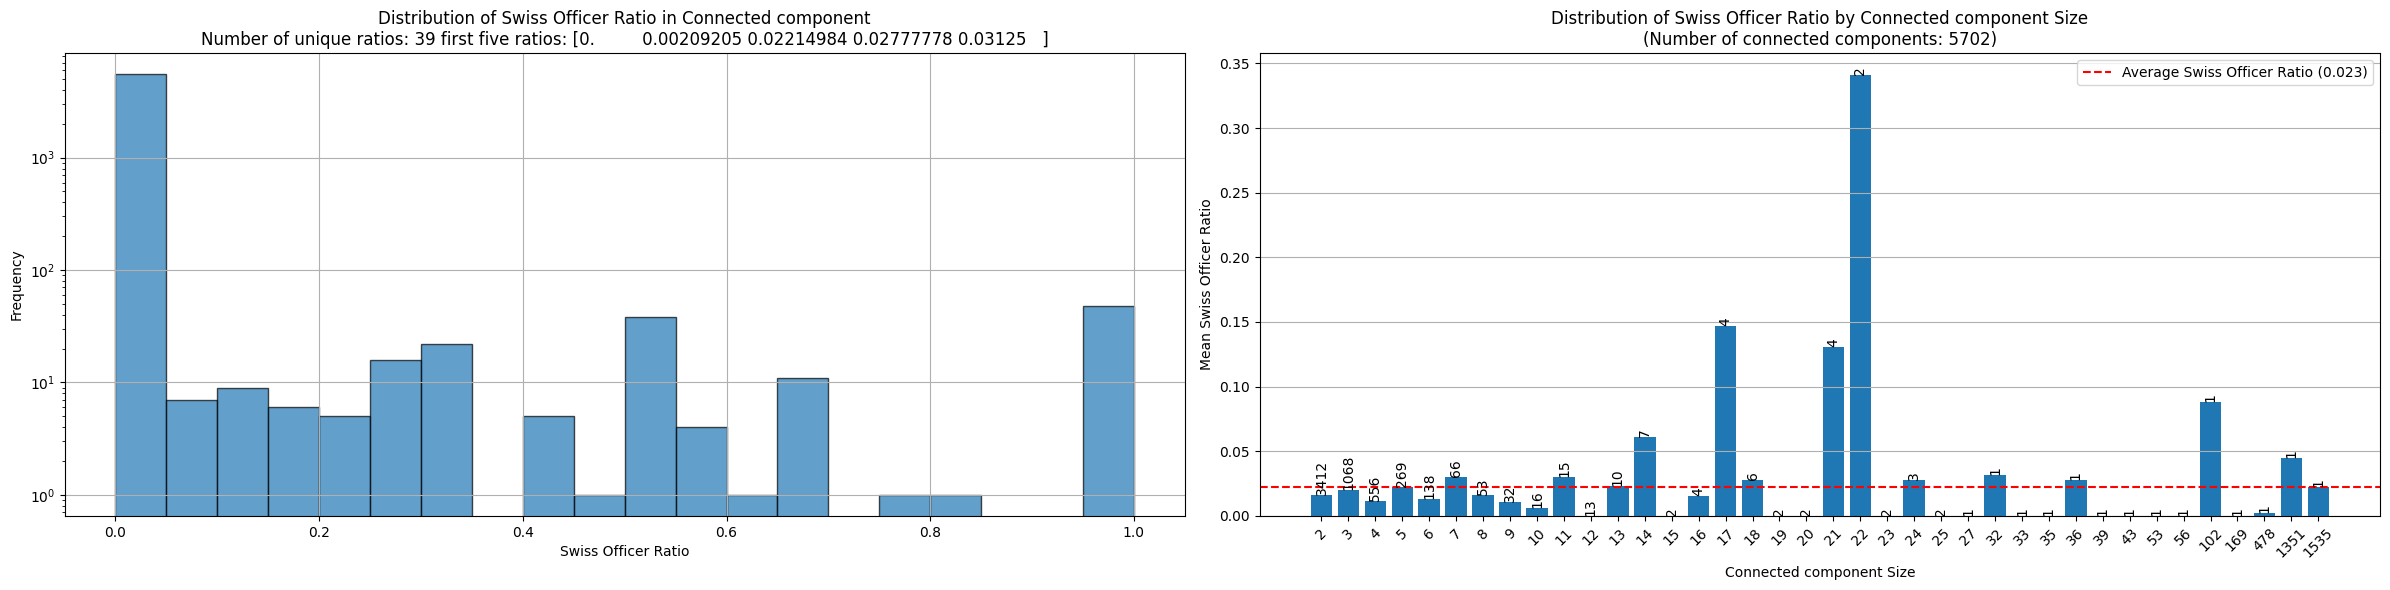

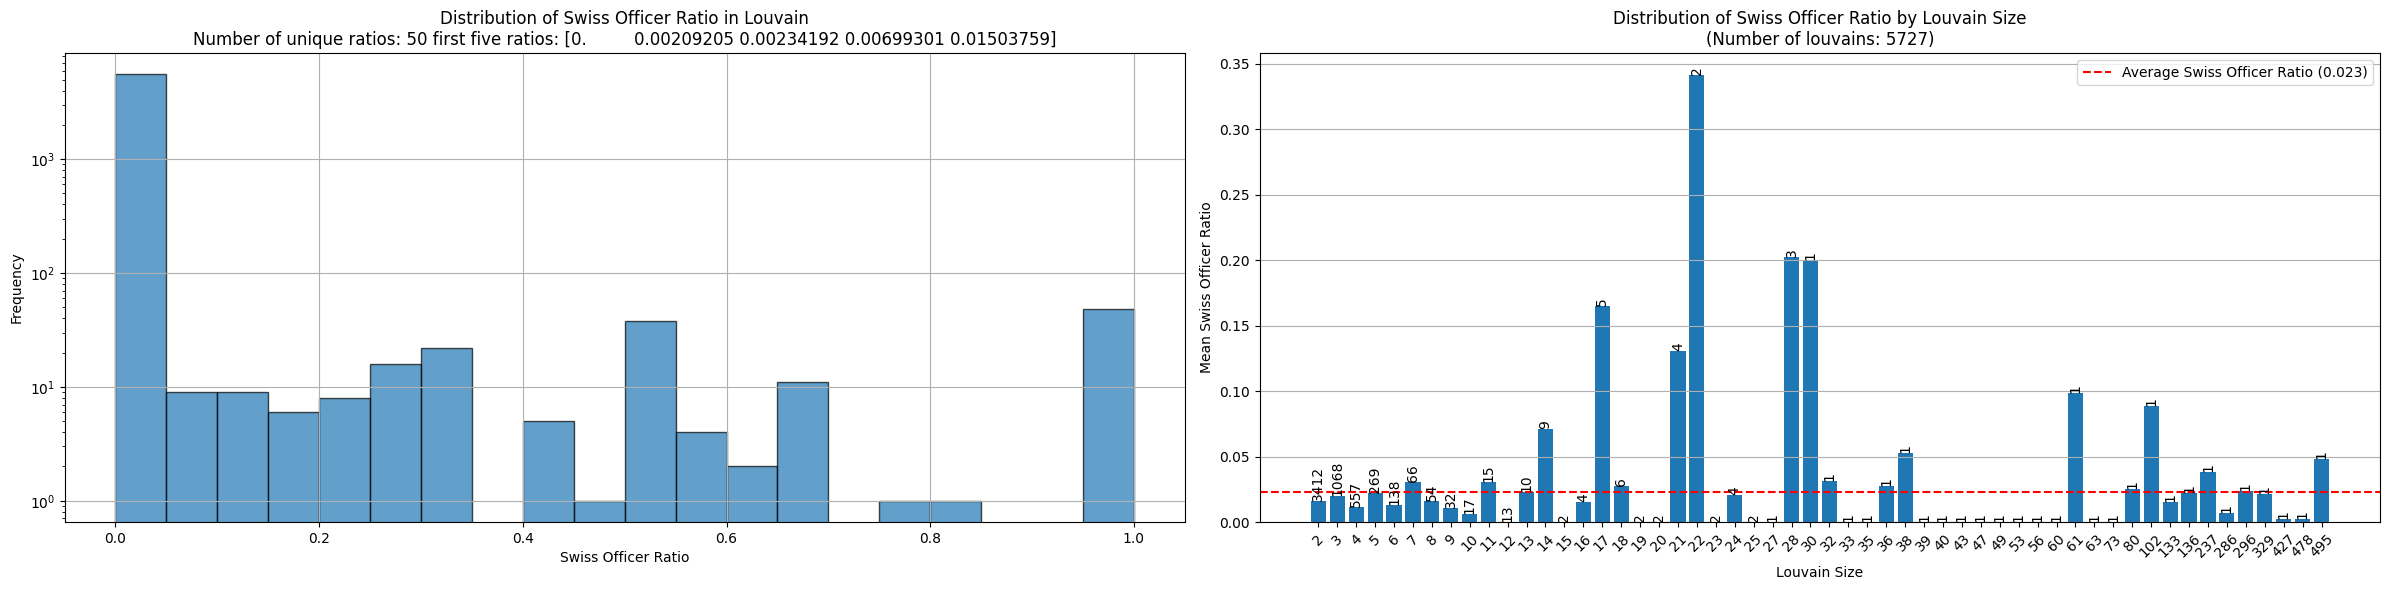

In [14]:
plot_swiss_officer_ratios_by_group(new_officers_graph, fast_label_propagation_communities, 'label propagation')
plot_swiss_officer_ratios_by_group(new_officers_graph, connected_components, 'connected component')
plot_swiss_officer_ratios_by_group(new_officers_graph, louvain_communities, 'louvain')

There seems to be almost no change in the distribution of ratios. But there are changes in the distribution of sizes. But these are mostly due to the big group sizes having very small number of groups but taking up a lot of the space on the graph.

In [15]:
analyse_top_10_groups(new_officers_graph, fast_label_propagation_communities)

Number of groups: 6092
clique 1 size: 235
Counter({'IDN': 45, 'NGA': 26, 'ARE': 23, 'MYS': 18, 'IND': 16, 'SGP': 13, 'GGY': 11, 'PAK': 8, 'nan': 8, 'HKG': 8, 'THA': 7, 'EGY': 6, 'GBR': 5, 'SAU': 4, 'KEN': 4, 'ZAF': 4, 'KWT': 3, 'PHL': 3, 'TWN': 3, 'TUR': 3, 'QAT': 3, 'ZWE': 2, 'LKA': 2, 'UGA': 2, 'OMN': 2, 'TZA': 2, 'CHE': 1, 'JPN': 1, 'JOR': 1, 'CHN': 1})

clique 2 size: 330
Counter({'KOR': 209, 'HKG': 43, 'CHN': 19, 'JPN': 9, 'VGB': 7, 'USA': 7, 'VNM': 6, 'SGP': 6, 'BGD': 4, 'RUS': 4, 'nan': 3, 'PHL': 3, 'CYM': 2, 'GBR': 2, 'DEU': 2, 'TWN': 1, 'ARE': 1, 'LUX': 1, 'WSM': 1})

clique 3 size: 227
Counter({'GBR': 32, 'ITA': 24, 'ESP': 20, 'DEU': 18, 'ARE': 11, 'FRA': 10, 'CAN': 8, 'RUS': 8, 'NLD': 8, 'TUR': 7, 'AUT': 6, 'GRC': 6, 'ZAF': 5, 'QAT': 5, 'CHE': 5, 'BRA': 4, 'PRT': 4, 'BEL': 3, 'HRV': 3, 'CZE': 3, 'ARG': 3, 'NGA': 2, 'NZL': 2, 'SVK': 2, 'SRB': 2, 'ROU': 2, 'IND': 2, 'THA': 1, 'ISR': 1, 'BGR': 1, 'JOR': 1, 'DZA': 1, 'MAR': 1, 'HUN': 1, 'GHA': 1, 'HND': 1, 'SVN': 1, 'HKG': 1, 'D

All top 10 largest communities are very heterogeneous.

In [16]:
analyse_top_10_groups(new_officers_graph, connected_components)

Number of groups: 5702
clique 1 size: 1206
Counter({'GBR': 188, 'ITA': 155, 'ESP': 115, 'DEU': 73, 'FRA': 45, 'BRA': 39, 'NLD': 35, 'CHE': 33, 'PRT': 31, 'ARG': 26, 'ARE': 26, 'ZAF': 23, 'BEL': 22, 'CAN': 22, 'GRC': 21, 'POL': 19, 'RUS': 19, 'NOR': 16, 'TUR': 12, 'FIN': 12, 'AUS': 11, 'SWE': 11, 'BGR': 11, 'AUT': 11, 'ROU': 9, 'VEN': 9, 'IRL': 8, 'CZE': 8, 'SVN': 8, 'SVK': 8, 'USA': 8, 'MYS': 7, 'KEN': 7, 'QAT': 7, 'ISR': 6, 'UKR': 6, 'LBN': 6, 'PAK': 6, 'nan': 5, 'NGA': 5, 'MLT': 5, 'ZMB': 4, 'CIV': 4, 'MCO': 4, 'AGO': 3, 'SRB': 3, 'NZL': 3, 'EGY': 3, 'MEX': 3, 'HRV': 3, 'ECU': 3, 'CHL': 3, 'THA': 3, 'IND': 3, 'SAU': 3, 'GHA': 3, 'AZE': 3, 'MWI': 3, 'HUN': 2, 'SGP': 2, 'MAR': 2, 'LVA': 2, 'PER': 2, 'VNM': 2, 'HKG': 2, 'JEY': 2, 'TUN': 2, 'DNK': 2, 'BLR': 2, 'MDA': 2, 'PHL': 2, 'MDG': 2, 'NIC': 2, 'SMR': 2, 'KAZ': 2, 'DZA': 1, 'COL': 1, 'TZA': 1, 'ALB': 1, 'GEO': 1, 'UZB': 1, 'BIH': 1, 'BGD': 1, 'MNG': 1, 'UGA': 1, 'JPN': 1, 'CYM': 1, 'BOL': 1, 'SYC': 1, 'HND': 1, 'URY': 1, 'CRI': 1, '

the top 2 communities are very heterogeneous while the rest is still heterogeneous but not as much as the top 2.

In [17]:
analyse_top_10_groups(new_officers_graph, louvain_communities)

Number of groups: 5725
clique 1 size: 762
Counter({'VGB': 210, 'RUS': 151, 'CYP': 129, 'nan': 33, 'CHE': 31, 'HKG': 25, 'ARE': 25, 'SGP': 16, 'JEY': 16, 'GBR': 10, 'UKR': 8, 'LIE': 7, 'CZE': 7, 'ISR': 6, 'GGY': 6, 'HUN': 5, 'AUT': 5, 'GIB': 4, 'SRB': 4, 'KAZ': 4, 'SYC': 4, 'AIA': 3, 'USA': 3, 'MCO': 3, 'PAN': 3, 'MLT': 2, 'ITA': 2, 'DEU': 2, 'IND': 2, 'ROU': 2, 'ARM': 2, 'IMN': 2, 'BHR': 2, 'TUR': 2, 'LUX': 2, 'NLD': 2, 'BRN': 2, 'JOR': 2, 'FRA': 1, 'BHS': 1, 'BGR': 1, 'ARG': 1, 'IDN': 1, 'LBR': 1, 'LVA': 1, 'AZE': 1, 'SAU': 1, 'CYM': 1, 'BLR': 1, 'PAK': 1, 'KNA': 1, 'HRV': 1, 'AUS': 1, 'TWN': 1, 'VGB;BRN': 1, 'CAN': 1})

clique 2 size: 578
Counter({'KOR': 346, 'HKG': 115, 'CHN': 33, 'USA': 12, 'JPN': 9, 'nan': 8, 'VGB': 8, 'VNM': 6, 'ITA': 6, 'SGP': 6, 'BGD': 4, 'RUS': 4, 'PHL': 3, 'LBR': 3, 'CYM': 2, 'TWN': 2, 'GBR': 2, 'DEU': 2, 'BRA': 1, 'ISR': 1, 'SYC': 1, 'ARE': 1, 'LUX': 1, 'MLT': 1, 'WSM': 1})

clique 3 size: 306
Counter({'IDN': 77, 'SGP': 36, 'ARE': 27, 'NGA': 26, 'MYS': 18, '

Again, all are very heterogeneous.

## Conclusion

It was discovered that Swiss officers play a relatively minor role in the larger international networks of offshore entities. The homogeneity of nationalities within the largest cliques and communities suggests that these networks are primarily dominated by officers from one countries when looking at very strict definitions of cliques. However, when relaxing the conditions, the networks become more heterogeneous.